## check the results of overlapped community resolution by Label Propagation Analysis (LPA)

Hw_huawei@123, such as: ssh spark@160.44.194.183
/home/spark/localcluster/tmp

In [1]:
import sys, os, gzip
add_libs = [
"/global/u1/z/zhwang/zhong/lib/python2.7/site-packages",
"/global/u1/z/zhwang/zhong/lib/python2.7/site-packages/IPython/extensions"
]
[sys.path.append(l) for l in add_libs]
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (12, 8)
%config InlineBackend.figure_format='retina'

In [2]:
def get_annotated_key(keyfile, inputfile):
    '''
    Label each read with annotated transcript id 
    If not labelled, use "na"
    return a dictionary seqID -> transcript_id
    
    '''
    ## read annotated transcripts
    keyinfo = {}
    if not(os.path.exists(keyfile) and os.path.exists(inputfile)):
        print "at least one of the input files are not found."
        sys.exit(0)
    with open(keyfile, 'r') as KEY:
        for lines in KEY:#.readlines():
            try:
                anarray = lines.strip("\n").split("\t")
                keyinfo[anarray[0]] = anarray[1]
            except:
                continue
    KEY.close()
    print "Number of reads in the annotation: " + '{:,d}'.format(len(keyinfo.keys()))
    known_clusters = pd.DataFrame.from_dict(keyinfo, 'index')
    known_clusters = known_clusters.rename(columns = {0:'transcript'})
    known_counts = known_clusters.groupby(['transcript']).size()
    print "Total reads in annotated clusters: " + '{:,d}'.format(known_counts[known_counts>1].sum())
    print "Total annotated clusters: " + '{:,d}'.format(sum(known_counts>1))
    print "The top 10 biggest annotated clusters are:"
    print known_counts.sort_values(ascending=False)[0:10]
    
    ## annotate input reads
    annotations = {}
    no_input_reads = 0
    no_annotated_reads = 0
    with open(inputfile, 'r') as IN:
        for lines in IN:#.readlines():
            seq_id,seq = lines.strip("\n").split("\t")
            header = seq_id.split(" ")[0]
            try:
                tid = keyinfo[header]
                no_annotated_reads += 1
            except:
                tid = 'na'
            annotations[seq_id] = tid    
            no_input_reads +=1
    print "Number of reads in the input: " + '{:,d}'.format(no_input_reads)
    print "Number of reads annotated in the input: " + '{:,d}'.format(no_annotated_reads)
    return annotations

def annotate_clusters(cluster, annotations):
    ''' 
    parse spark cluster results
    cluster file format is: seqid \t cluster_id
    return: [seq_name, cluster_id, annotation_transcript]
    
    ''' 
    if not os.path.exists(cluster):
        print "Cluster file not found."
        sys.exit(0)
        
    results = []
    total_clustered_reads = 0
    total_clustered_annotated = 0
    with gzip.open(cluster, 'r') as IN:
        for lines in IN:#.readlines():
            seq_id, group_id = lines.strip("\n").split("\t")
            total_clustered_reads += 1
            if group_id > 0 and annotations[seq_id] != 'na':
                results.append([seq_id, group_id, annotations[seq_id]])
                total_clustered_annotated += 1
                
    IN.close()
    print "Total reads in clusters: " + '{:,d}'.format(total_clustered_reads)
    print "Total annotated reads in clusters: " + '{:,d}'.format(total_clustered_annotated)

    return pd.DataFrame(results) 


In [3]:
def get_nmi(config, min_cluster_size):
    cluster_ids = set(config[1])
    data = []
    for name,group in config.groupby([2]):
        if len(group)<min_cluster_size:
            continue
        d = {c:0 for c in cluster_ids}    
        for g in group[1]:
            d[g] +=1
        d.pop('-1', None) # remove unclustered reads   
        data.append([d[k] for k in sorted(d.keys())]) 
    data = np.array(data).astype(float) 
    tc = np.copy(data)
    tcp = tc/np.sum(tc)
    ws = [ np.sum(tc[i])/(np.sum(tc)+0.0000000000001) for i in xrange(len(tc))]
    cs = [ np.sum(np.transpose(tc)[i])/(np.sum(tc)+0.0000000000001) for i in xrange(len(np.transpose(tc)))]
    if len(ws)>1 and len(cs)>1:
        II = 0
        for i in xrange(len(ws)):
            for j in xrange(len(cs)):
                II += tcp[i][j] * np.log((tcp[i][j])/(cs[j]*ws[i]+0.0000000000001) + 0.000000000001)
        Hc = np.sum([ -csi * np.log(csi + 0.000000000001) for csi in cs])
        Hw = np.sum([ -cwi * np.log(cwi + 0.000000000001) for cwi in ws])
        H = (Hc+Hw)*0.5
        NMI = II/H
        return NMI,II
    else:
        return 'len 1'
    


In [72]:
def clustering_stat(config, figure_name):
    '''
    [seq_name, cluster_id, annotation_transcript]
    '''
    ## purity
    grouped = config1.groupby([1])
    cluster_results = []
    for name,group in grouped:
        if len(group)<2:
            continue
        counts = group.groupby([2]).count()[0]
        cluster_results.append([ len(counts), sum(counts), max(counts), counts[counts == max(counts)].index[0]])
    cluster_results = pd.DataFrame(cluster_results)
    clustered_reads = sum(cluster_results[1])
    print "Total clusters from Input: " + '{:,d}'.format(cluster_results.shape[0])
    print '{:,d}'.format(clustered_reads) + " reads are in clusters"
    top10 = cluster_results.sort_values([1], ascending=[0])[0:10]
    
    print "The largest 10 clusters are:"
    print "#transcripts\treads\tpurity\tID"
    for c in top10.iterrows():  
        c1, c2, c3, c4 = c[1]
        print "%d\t\t%d\t%.2f\t%s" % (c1, c2, 100.0*c3/c2, c4)
    print "Percent of 100% pure clusters: " + '{:.2f}'.format(100.0* sum(cluster_results[0] == 1)/cluster_results.shape[0])
    print "Median purity: " + '{:.2f}'.format(np.median(100.0* cluster_results[2] / cluster_results[1]))
    #print "Mean purity: " + '{:.2f}'.format(np.mean(100.0* cluster_results[:,2] / cluster_results[:,1]))
#    nmi, ii = get_nmi(config, 2) 
#    print "Normalized Mutual Information: " + '{:.2f}'.format(nmi)
    # completeness
    grouped = config.groupby([2])
    completeness = []
    for name,group in grouped:
        if len(group) <= 2:
            continue
        counts = group.groupby([1]).count()[0]
        completeness.append([max(counts), sum(counts)])
    completeness = np.array(completeness)    
    median_completeness = np.median(100.0 * completeness[:,0] / completeness[:,1])
    mean_completeness = np.mean(100.0 * completeness[:,0] / completeness[:,1])
    
    print "The most abundant transcript has " + '{:,d}'.format(max(completeness[:,1]))  + " copies."
    print "Median completeness: " + '{:.2f}'.format(median_completeness)    
    #print "Mean completeness: " + '{:.2f}'.format(mean_completeness)    
    
    fig1 = plt.figure(num=1, figsize=(12, 12), dpi=300)
    plt.subplots_adjust( wspace=.1, hspace=.1 )

    ax1 = fig1.add_subplot(3,3,1)
    ax1.set_title('Clusters Size (log10) vs purity')
    ax1.set_ylim(top=102)
    x = np.log10(cluster_results[1])
    y = 100.0* cluster_results[2] / cluster_results[1]
    sns.kdeplot(x, y,shade=True, shade_lowest=False, n_levels=100, ax=ax1);

    ax2 = fig1.add_subplot(3,3,2)
    ax2.set_title('#Transcripts(log2) per Cluster')
    sns.distplot(np.log2(cluster_results[0]), kde=False, bins=100, ax=ax2)
    
    ax3 = fig1.add_subplot(3,3,3)
    ax3.set_title('#Transcripts (log10) vs completeness')
    ax3.set_ylim(top=102)
    x = np.log10(completeness[:,1])
    y = 100.0 * completeness[:,0] / completeness[:,1]
    sns.kdeplot(x, y,shade=True, shade_lowest=False, n_levels=100, ax=ax3);

    # large clusters
    large = 1
    x = np.log10(cluster_results[1])
    sel = x>=large
    if np.sum(sel)>10:
        ax4 = fig1.add_subplot(3,3,4)
        ax4.set_title('Clusters Size(log10) vs purity')
        y = 100.0* cluster_results[2] / cluster_results[1]
        sns.kdeplot(x[sel], y[sel], n_levels=10, shade=True, shade_lowest=False, ax=ax4);
        ax4.set_xlim(left=0)
        ax4.set_ylim(top=102)

        ax5 = fig1.add_subplot(3,3,5)
        ax5.set_title('#Transcripts(log2) per Cluster')
        ax5.set_ylim(top=2000)
        sns.distplot(np.log2(cluster_results[0]), kde=False, ax=ax5)

        ax6 = fig1.add_subplot(3,3,6)
        ax6.set_title('#Transcripts (log10) vs completeness')
        x = np.log10(completeness[:,1])
        sel = x>=large
        y = 100.0 * completeness[:,0] / completeness[:,1]
        sns.kdeplot(x[sel], y[sel], n_levels=10, shade=True, shade_lowest=False, ax=ax6);
        ax6.set_xlim(left=0)
        ax6.set_ylim(top=102)
 
    # largest clusters
    large = 2
    x = np.log10(cluster_results[1])
    sel = x>=large 
    if np.sum(sel)>1:
        ax7 = fig1.add_subplot(3,3,7)
        ax7.set_title('Clusters Size(log10) vs purity')
        y = 100.0* cluster_results[2] / cluster_results[1]
        sns.regplot(x=x[sel], y=y[sel], ax=ax7);
        ax7.set_xlim(left=0)
        ax7.set_ylim(top=102)

        ax8 = fig1.add_subplot(3,3,8)
        ax8.set_title('#Transcripts(log2) per Cluster')
        ax8.set_ylim(top=100)
        sns.distplot(np.log2(cluster_results[0]), kde=False, ax=ax8)

        ax9 = fig1.add_subplot(3,3,9)
        ax9.set_title('#Transcripts (log10) vs completeness')
        x = np.log10(completeness[:,1])
        sel = x>=large
        y = 100.0 * completeness[:,0] / completeness[:,1]
        sns.regplot(x=x[sel], y=y[sel], ax=ax9);
        ax9.set_xlim(left=0)
        ax9.set_ylim(top=102)
    
    sns.plt.tight_layout()
    sns.plt.show()
    fig1.savefig(figure_name + '.pdf', format='pdf') 

In [5]:
inputfile = '/home/spark/data/raw/maize/notcombinednew.seq'
keyfile = "/home/spark/localcluster/tmp/notcombined.mapping.filtered.csv"
keyinfo = get_annotated_key(keyfile, inputfile)

Number of reads in the annotation: 2,561,160
Total reads in annotated clusters: 2,561,149
Total annotated clusters: 972
The top 10 biggest annotated clusters are:
transcript
Zm00001d006596_T001    271200
Zm00001d005334_T001    256127
Zm00001d050100_T001    179335
GRMZM5G815453_T01       95850
Zm00001d002721_T001     81231
Zm00001d051261_T001     72538
Zm00001d013007_T001     69461
Zm00001d043168_T001     53618
Zm00001d014673_T001     51457
Zm00001d038923_T001     46431
dtype: int64
Number of reads in the input: 147,749,547
Number of reads annotated in the input: 2,561,160


Total clusters from Input: 121,295
2,135,673 reads are in clusters
The largest 10 clusters are:
#transcripts	reads	purity	ID
7		1032	63.57	Zm00001d004731_T002
7		978	15.24	Zm00001d051075_T007
1		946	100.00	Zm00001d045952_T001
1		900	100.00	Zm00001d015905_T001
1		842	100.00	Zm00001d006596_T001
1		838	100.00	Zm00001d053526_T001
15		838	8.59	Zm00001d031543_T001
1		832	100.00	Zm00001d052559_T001
1		798	100.00	Zm00001d004519_T001
2		790	50.63	Zm00001d030958_T002
Percent of 100% pure clusters: 72.46
Median purity: 100.00
The most abundant transcript has 229,568 copies.
Median completeness: 19.62


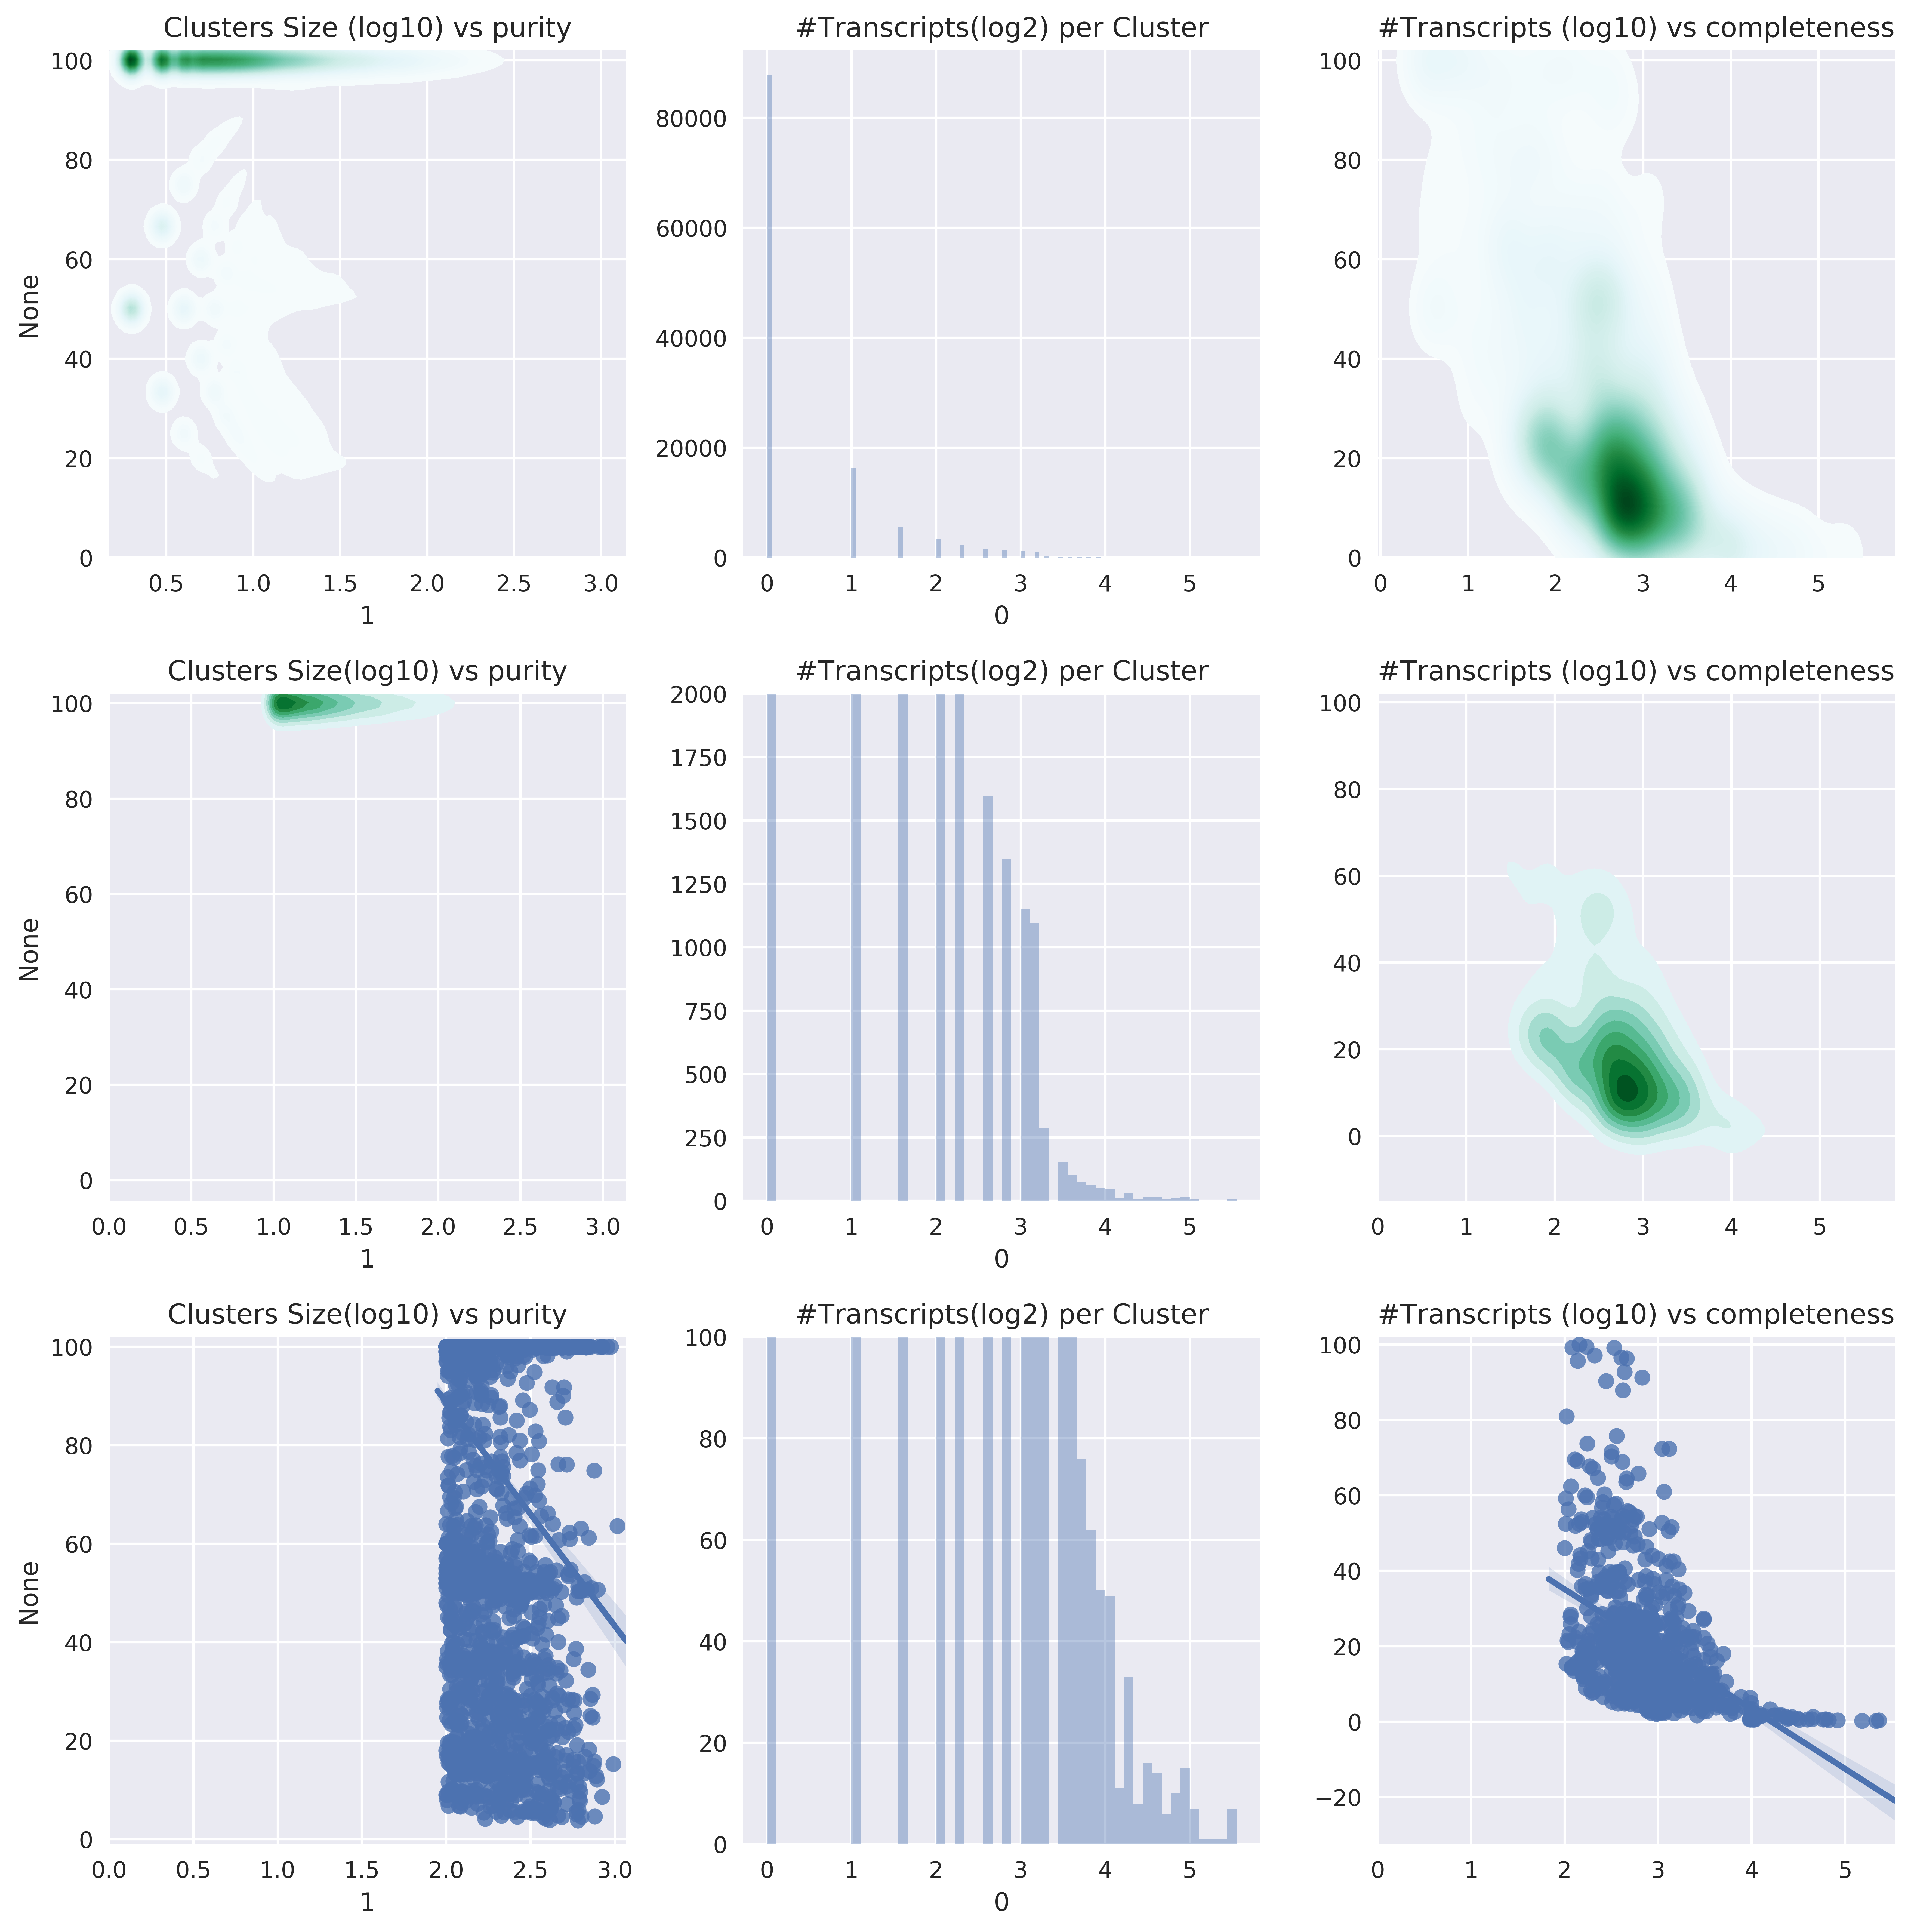

In [73]:
'''
k=31
c=0.02 

min_kmer_count=2
max_kmer_count=1000

min_shared_kmers=10
max_shared_kmers=500
min_reads_per_cluster=2
'''
config1 = annotate_clusters('../tmp/maize45Gnew_lpaseq.txt_31.c0.02.gz', keyinfo)
clustering_stat(config1, 'k31min20')